In [1]:
"""
### Yêu cầu 1: Chuẩn hóa và làm sạch dữ liệu

1. Chuẩn hóa cột salary về dạng số, xử lý các giá trị như "Thoả thuận", "Trên X triệu", "X - Y triệu", "Tới X triệu", etc.
2. Tạo thêm các cột phụ: min_salary, max_salary, salary_unit (VND/USD)
3. Xử lý cột address để tách thành city và district
4. Chuẩn hóa job_title để gom nhóm các vị trí tương tự (ví dụ: "Software Engineer", "Developer", "Programmer" có thể gom vào một nhóm)

### Yêu cầu 2: Xây dựng Data Pipeline

1. Thiết kế luồng ETL cơ bản: Extract từ CSV -> Transform dữ liệu -> Load vào database (MySQL hoặc PostgresDB)
2. Thiết lập schedule job tự động chạy pipeline
3. Xây dựng error handling cho các trường hợp lỗi phổ biến

### Yêu cầu 3: Phân tích dữ liệu

1. Vẽ biểu đồ phân bố mức lương theo vị trí
2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực
3. Biểu đồ xu hướng công nghệ hot

*Lưu ý quan trọng:*

- Sử dụng version control (git) cho code
- Viết unit test cho các hàm xử lý dữ liệu
"""

'\n### Yêu cầu 1: Chuẩn hóa và làm sạch dữ liệu\n\n1. Chuẩn hóa cột salary về dạng số, xử lý các giá trị như "Thoả thuận", "Trên X triệu", "X - Y triệu", "Tới X triệu", etc.\n2. Tạo thêm các cột phụ: min_salary, max_salary, salary_unit (VND/USD)\n3. Xử lý cột address để tách thành city và district\n4. Chuẩn hóa job_title để gom nhóm các vị trí tương tự (ví dụ: "Software Engineer", "Developer", "Programmer" có thể gom vào một nhóm)\n\n### Yêu cầu 2: Xây dựng Data Pipeline\n\n1. Thiết kế luồng ETL cơ bản: Extract từ CSV -> Transform dữ liệu -> Load vào database (MySQL hoặc PostgresDB)\n2. Thiết lập schedule job tự động chạy pipeline\n3. Xây dựng error handling cho các trường hợp lỗi phổ biến\n\n### Yêu cầu 3: Phân tích dữ liệu\n\n1. Vẽ biểu đồ phân bố mức lương theo vị trí\n2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực\n3. Biểu đồ xu hướng công nghệ hot\n\n*Lưu ý quan trọng:*\n\n- Sử dụng version control (git) cho code\n- Viết unit test cho các hàm xử lý dữ liệu\n'

In [2]:
import polars as pl

In [3]:
path = 'C:/Users/ADMIN/Desktop/Data Engineering/task_19122024/data.csv'
df = pl.read_csv(path)

Yêu cầu 1: Chuẩn hóa và làm sạch dữ liệu

1. Chuẩn hóa cột salary về dạng số, xử lý các giá trị như "Thoả thuận", "Trên X triệu", "X - Y triệu", "Tới X triệu", etc.
2. Tạo thêm các cột phụ: min_salary, max_salary, salary_unit (VND/USD)

In [4]:
#Loại bỏ nhiều khoảng trắng liền nhau và thay bằng 1 khoảng trắng
df = df.with_columns(pl.col('salary').str.replace_all(r'\s+', ' ', literal=False).alias('cleaned_salary'))

#Loại bỏ khoảng trắng ở đầu
df = df.with_columns(pl.col("cleaned_salary").str.strip_chars_start(' ').alias('cleaned_salary'))

#Loại bỏ khoảng trắng ở cuối
df = df.with_columns(pl.col("cleaned_salary").str.strip_chars_end(' ').alias('cleaned_salary'))

In [5]:
#Kiểm tra quy luật cột cleaned_salary, thay thế số tiền là x (Vẫn giữ nguyên dấu chấm và dấu phẩy trong x)
print(df.with_columns(
    pl.col('cleaned_salary').str.replace_all(r'\d+(?:[.,]\d+)*', 'x')
).select('cleaned_salary').unique())

# Đơn vị là triệu và USD
# record có 2 giá trị x, x nào lớn là max, nhỏ là min
# record có 2 giá trị x, nếu chứa 'Tới' thì max_salary = x. nếu chứa 'Trên' min_salary = x

shape: (7, 1)
┌────────────────┐
│ cleaned_salary │
│ ---            │
│ str            │
╞════════════════╡
│ Tới x USD      │
│ x - x USD      │
│ Trên x USD     │
│ Tới x triệu    │
│ Trên x triệu   │
│ x - x triệu    │
│ Thoả thuận     │
└────────────────┘


In [6]:
#Thêm cột salary_unit
df = df.with_columns(
    pl.when(pl.col('cleaned_salary').str.to_lowercase().str.contains('triệu')).then(pl.lit('VND'))
    .when(pl.col('cleaned_salary').str.to_lowercase().str.contains('usd')).then(pl.lit('USD'))
    .otherwise(pl.lit(None)).alias("salary_unit")
)

df = df.with_columns(
    pl.col('cleaned_salary')
    .str.replace_all(r'[^\d+(?:[.,]\d+)*\s]', '')  # Loại bỏ ký tự không phải x và khoảng trắng
    .alias('salary_number')
)

#Loại bỏ nhiều khoảng trắng liền nhau và thay bằng 1 khoảng trắng
df = df.with_columns(pl.col('salary_number').str.replace_all(r'\s+', ' ', literal=False))

# Loại bỏ khoảng trắng ở đầu
df = df.with_columns(pl.col("salary_number").str.strip_chars_start(' ').alias('salary_number'))

#Loại bỏ khoảng trắng ở cuối
df = df.with_columns(pl.col("salary_number").str.strip_chars_end(' ').alias('salary_number'))

#Tách record cột salary_number thành list, từ text phân tách qua 1 khoảng trắng
df = df.with_columns(
    pl.col('salary_number').str.split(' ')
)
#Tạo cột min_salary, max_salary theo logic
df = df.with_columns(
    pl.when(pl.col('cleaned_salary').str.contains('Tới') | pl.col('cleaned_salary').str.contains('Thoả thuận')).then(pl.lit(None))
    .otherwise((pl.col("salary_number").map_elements(lambda x: x[0])))
    .alias('min_salary'),
    pl.when(pl.col('cleaned_salary').str.contains('Tới')).then(pl.col("salary_number").map_elements(lambda x: x[0]))
    .otherwise((pl.col("salary_number").map_elements(lambda x: x[1])))
    .alias('max_salary')
)

#Xử lý vấn đề cột min_salary và max_salary chứa dấu "." và dấu "," Quy ước dấu chấm để phân tách thập phân, dấu phẩy để tách phần nghìn => loại bỏ dấu phẩy
df = df.with_columns(pl.col('min_salary').str.replace_all(',', ''),
                     pl.col('max_salary').str.replace_all(',', ''))
# Dấu chấm giữ nguyên vào chuyển thẳng định dạng sang float
df = df.with_columns(
    pl.col('min_salary').cast(pl.Float32),
    pl.col('max_salary').cast(pl.Float32)
)
#Chuyển min_salary và max_salary về đúng giá trị với các trường hợp unit là VND, do đơn vị gốc là triệu
df = df.with_columns(
    pl.when(pl.col('salary_unit') == 'VND').then(pl.col('min_salary')*1000000).otherwise(pl.col('min_salary')).alias('min_salary'),
    pl.when(pl.col('salary_unit') == 'VND').then(pl.col('max_salary')*1000000).otherwise(pl.col('max_salary')).alias('max_salary')
)

#Chuyển lại định dạng thành Int
df = df.with_columns(
    pl.col('min_salary').cast(pl.Int32),
    pl.col('max_salary').cast(pl.Int32)
)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


In [7]:
#Kiểm tra có giá trị max nào nhỏ hơn min không
len(df.filter(pl.col('max_salary') < pl.col('min_salary')))

0

In [8]:
df

created_date,job_title,company,salary,address,time,link_description,cleaned_salary,salary_unit,salary_number,min_salary,max_salary
str,str,str,str,str,str,str,str,str,list[str],i32,i32
"""2023-08-01""","""Business Analyst""","""Công ty TNHH Công nghệ số Adam…","""10 - 20 triệu""","""Hà Nội""","""Còn 25 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""10 - 20 triệu""","""VND""","[""10"", ""20""]",10000000,20000000
"""2023-08-01""","""Nhân Viên Lập Trình Phần Mềm -…","""Công ty TNHH Đầu Tư Công Nghệ …","""10 - 20 triệu""","""Hồ Chí Minh""","""Còn 91 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""10 - 20 triệu""","""VND""","[""10"", ""20""]",10000000,20000000
"""2023-08-01""",""".Net Developer (N3) | T9160""","""Công ty TNHH CMC GLOBAL""","""Thoả thuận""","""Toàn Quốc""","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Thoả thuận""",null,"[""""]",null,null
"""2023-08-01""","""Project Manager (Tiếng Anh Gia…","""CÔNG TY CỔ PHẦN CÔNG NGHỆ SOTA…","""Tới 35 triệu""","""Hà Nội: Cầu Giấy""","""Còn 25 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 35 triệu""","""VND""","[""35""]",null,35000000
"""2023-08-01""","""Devops/Sre - Chuyên Viên Quản …","""Công ty Cổ phần Thời Trang Yod…","""Tới 50 triệu""","""Hà Nội: Thanh Xuân: Hải Dương:…","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 50 triệu""","""VND""","[""50""]",null,50000000
…,…,…,…,…,…,…,…,…,…,…,…
"""2023-08-01""","""Thực Tập Sinh Dotnet""","""Công ty TNHH 1 thành viên công…","""Thoả thuận""","""Hà Nội: Thanh Xuân: Hồ Chí Min…","""Còn 4 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Thoả thuận""",null,"[""""]",null,null
"""2023-08-01""","""Thực Tập Sinh Kỹ Thuật Máy Tín…","""Công Ty Cổ Phần Đầu Tư Công Ng…","""Trên 3 triệu""","""Hà Nội: Hà Đông, Cầu Giấy""","""Còn 26 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Trên 3 triệu""","""VND""","[""3""]",3000000,null
"""2023-08-01""","""Project Manager""","""Công ty CP Nghiên cứu và phát …","""Tới 50 triệu""","""Hà Nội""","""Còn 29 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 50 triệu""","""VND""","[""50""]",null,50000000


3. Xử lý cột address để tách thành city và district

In [9]:
df = df.with_row_index("id", offset=1000)

In [10]:
dfa_address = df.clone()

In [11]:
list_city_name = ['Hồ Chí Minh','Hưng Yên','Đà Nẵng','Khánh Hòa','Bình Dương','Bắc Ninh','Đồng Nai','An Giang','Bà Rịa - Vũng Tàu',
                  'Bình Thuận','Hải Phòng','Lâm Đồng','Ninh Thuận','Quảng Ngãi','Bình Định','Sóc Trăng','Kiên Giang','Quảng Nam','Quảng Ninh','Thừa Thiên Huế', 'Cần Thơ',
                  'Vĩnh Phúc','Phú Thọ','Bắc Giang','Hà Nam','Hải Dương','Thái Bình','Thái Nguyên','Phú Yên','Tây Ninh','Long An','Bạc Liêu',
                  'Đắk Lắk','Gia Lai','Thanh Hóa','Nghệ An','Hà Tĩnh','Ninh Bình','Quảng Trị','Bến Tre','Cà Mau','Đồng Tháp','Tiền Giang',
                  'Trà Vinh','Vĩnh Long','Bình Phước','Đắk Nông','Điện Biên','Hậu Giang','Kon Tum','Lai Châu','Lạng Sơn','Nam Định','Quảng Bình','Sơn La','Yên Bái','Hà Nội',
                  'Hoà Bình','Bắc Kạn','Cao Bằng','Hà Giang','Lào Cai','Tuyên Quang', 'Toàn Quốc', 'Thanh Hoá', 'Khánh Hoà', 'Nước Ngoài']

In [12]:
regex_pattern = '|'.join(list_city_name)
dfa_address = dfa_address.with_columns(
    pl.col('address').str.replace_all(regex_pattern, 'x').alias('address_city')
)

dfa_address = dfa_address.with_columns(
    pl.col('address').str.split(': ').alias('address_split')
)

dfa_address = dfa_address.explode('address_split')

dfa_address = dfa_address.with_columns(
    pl.when(pl.col('address_split').is_in(list_city_name)).then(pl.col('address_split')).otherwise(pl.lit(None)).alias('city'),
    pl.when(~pl.col('address_split').is_in(list_city_name)).then(pl.col('address_split')).otherwise(pl.lit(None)).alias('district')
)

dfa_address = dfa_address.with_columns(
    pl.col('city').fill_null(strategy="forward")
)

dfa_address = dfa_address.with_columns(
    pl.col('district').str.split(', ').alias('district')
)

dfa_address = dfa_address.explode('district')

dfa_address = dfa_address.group_by(['id', 'city']).agg(
    pl.col('district').filter(pl.col('district').is_not_null()).alias('district')
)

dfa_address = dfa_address.explode('district')

In [13]:
df = df.join(dfa_address, how='left', on = 'id')

In [14]:
df

id,created_date,job_title,company,salary,address,time,link_description,cleaned_salary,salary_unit,salary_number,min_salary,max_salary,city,district
u32,str,str,str,str,str,str,str,str,str,list[str],i32,i32,str,str
1000,"""2023-08-01""","""Business Analyst""","""Công ty TNHH Công nghệ số Adam…","""10 - 20 triệu""","""Hà Nội""","""Còn 25 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""10 - 20 triệu""","""VND""","[""10"", ""20""]",10000000,20000000,"""Hà Nội""",null
1001,"""2023-08-01""","""Nhân Viên Lập Trình Phần Mềm -…","""Công ty TNHH Đầu Tư Công Nghệ …","""10 - 20 triệu""","""Hồ Chí Minh""","""Còn 91 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""10 - 20 triệu""","""VND""","[""10"", ""20""]",10000000,20000000,"""Hồ Chí Minh""",null
1002,"""2023-08-01""",""".Net Developer (N3) | T9160""","""Công ty TNHH CMC GLOBAL""","""Thoả thuận""","""Toàn Quốc""","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Thoả thuận""",null,"[""""]",null,null,"""Toàn Quốc""",null
1003,"""2023-08-01""","""Project Manager (Tiếng Anh Gia…","""CÔNG TY CỔ PHẦN CÔNG NGHỆ SOTA…","""Tới 35 triệu""","""Hà Nội: Cầu Giấy""","""Còn 25 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 35 triệu""","""VND""","[""35""]",null,35000000,"""Hà Nội""","""Cầu Giấy"""
1004,"""2023-08-01""","""Devops/Sre - Chuyên Viên Quản …","""Công ty Cổ phần Thời Trang Yod…","""Tới 50 triệu""","""Hà Nội: Thanh Xuân: Hải Dương:…","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 50 triệu""","""VND""","[""50""]",null,50000000,"""Hải Dương""","""TP Hải Dương"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2929,"""2023-08-01""","""Thực Tập Sinh Kỹ Thuật Máy Tín…","""Công Ty Cổ Phần Đầu Tư Công Ng…","""Trên 3 triệu""","""Hà Nội: Hà Đông, Cầu Giấy""","""Còn 26 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Trên 3 triệu""","""VND""","[""3""]",3000000,null,"""Hà Nội""","""Hà Đông"""
2929,"""2023-08-01""","""Thực Tập Sinh Kỹ Thuật Máy Tín…","""Công Ty Cổ Phần Đầu Tư Công Ng…","""Trên 3 triệu""","""Hà Nội: Hà Đông, Cầu Giấy""","""Còn 26 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Trên 3 triệu""","""VND""","[""3""]",3000000,null,"""Hà Nội""","""Cầu Giấy"""
2930,"""2023-08-01""","""Project Manager""","""Công ty CP Nghiên cứu và phát …","""Tới 50 triệu""","""Hà Nội""","""Còn 29 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…","""Tới 50 triệu""","""VND""","[""50""]",null,50000000,"""Hà Nội""",null


4. Chuẩn hóa job_title để gom nhóm các vị trí tương tự (ví dụ: "Software Engineer", "Developer", "Programmer" có thể gom vào một nhóm)

In [15]:
df['job_title'].unique().to_list()

['Aem Front-End Developer (React, Adobe, Java)',
 'Lập Trình Viên Unity/C#',
 'Middle Fullstack',
 'React Native Developer Spoken English (Upto 40M)',
 'Leader IT Communicator',
 'Chuyên Viên Quản Trị Hệ Thống | System Administration (Sa)',
 'Lập Trình Viên Mobile Flutter',
 'Nhân Viên Lập Trình .Net (Up To 15 - 25Triệu/Tháng)',
 'Java Developer (Ecommerce Platform)',
 'Front End Developer ( Thu Nhập Lên Đến 1000 Usd )',
 'Senior Software Engineer (Devops)',
 'Business Analyst/ Product Owner',
 'Java Developer | T9147',
 'Frontend Web Application Developer',
 'Powerapps Specialist',
 'IT Business Development - Chuyên Viên Phát Triển Doanh Nghiệp',
 'Nhân Viên 2D Artist - Cầu Giấy Hà Nội',
 'Fresher React Native Developer (Up To 10M)',
 'Automation Test',
 'Thực Tập Tiếng Thái (Tester Tiếng Thái)',
 'Lập Trình Viên Mobile (Flutter Developer)',
 'Data Governance - Salary Up To $3000',
 'Thực Tập Sinh IT - Lập Trình Web',
 'Middle Front End Dev (Reactjs)',
 'Product Owner',
 'Unity Deve

In [16]:
#Đếm số lượng cụm từ xuất hiện trong trường
from collections import Counter

dataframe_wordcloud = df.with_columns(pl.col('job_title').str.split(' ').alias('words'))

list_word = []
len_max = 4
len_min = 2
for text in dataframe_wordcloud['words']: 
    for length in range(len_min, len_max + 1):
        for i in range(len(text) - length + 1):
            group_of_words = ' '.join(text[i:i+length])
            list_word.append(group_of_words)

word_counts1 = Counter(list_word)

In [17]:
df = df.with_columns(
    pl.col('job_title').str.to_lowercase().alias('job_title_lowercase')
)

df = df.with_columns(
    pl.when(pl.col('job_title_lowercase').str.contains('lập trình|developer|fullstack|nhân viên kỹ thuật|front-end|phần mềm|backend|frontend')).then(pl.lit('Developer'))
    .when(pl.col('job_title_lowercase').str.contains('business analyst|phân tích nghiệp vụ')).then(pl.lit('Business Analyst'))
    .when(pl.col('job_title_lowercase').str.contains('project manager|quản trị dự án')).then(pl.lit('Project Manager'))
    .when(pl.col('job_title_lowercase').str.contains('software engineer')).then(pl.lit('Software Engineer'))
    .when(pl.col('job_title_lowercase').str.contains('thực tập|intern')).then(pl.lit('Intern'))
    .when(pl.col('job_title_lowercase').str.contains('designer')).then(pl.lit('Designer'))
    .when(pl.col('job_title_lowercase').str.contains('nhân viên hỗ trợ|support|helpdesk|nhập liệu')).then(pl.lit('IT Support'))
    .when(pl.col('job_title_lowercase').str.contains('robotics')).then(pl.lit('Robotics'))
    .when(pl.col('job_title_lowercase').str.contains('tester|kiểm thử')).then(pl.lit('Tester'))
    .when(pl.col('job_title_lowercase').str.contains('hệ thống|hạ tầng')).then(pl.lit('System Administrator'))
    .when(pl.col('job_title_lowercase').str.contains('vận hành|quản trị cơ sở dữ')).then(pl.lit('Operations Specialist'))
    .when(pl.col('job_title_lowercase').str.contains('data analyst|data engineer')).then(pl.lit('Data Analyst/Engineer'))
    .when(pl.col('job_title_lowercase').str.contains('ai')).then(pl.lit('AI'))
    .otherwise(pl.lit('Other')).alias('Job_group')
)

df = df.with_columns(
    pl.col('created_date').str.to_date("%Y-%m-%d")
)

In [18]:
final_table = df[['id','created_date', 'job_title', 'Job_group', 'company', 'salary', 'min_salary', 'max_salary', 'salary_unit', 'address', 'city', 'district', 'time', 'link_description']]

In [19]:
final_table.filter(pl.col('Job_group') == 'Software Engineer')

id,created_date,job_title,Job_group,company,salary,min_salary,max_salary,salary_unit,address,city,district,time,link_description
u32,date,str,str,str,str,i32,i32,str,str,str,str,str,str
1020,2023-08-01,"""Embedded Software Engineer (Io…","""Software Engineer""","""FPT Software""","""Thoả thuận""",null,null,null,"""Hà Nội""","""Hà Nội""",null,"""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
1107,2023-08-01,"""Bridge Software Engineer (.Net…","""Software Engineer""","""FPT Software""","""Thoả thuận""",null,null,null,"""Hồ Chí Minh: Quận 9""","""Hồ Chí Minh""","""Quận 9""","""Còn 29 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
1166,2023-08-01,"""Kỹ Sư Cầu Nối - Brigde Softwar…","""Software Engineer""","""Công ty TNHH Sản xuất phần mềm…","""1,000 - 3,000 USD""",1000,3000,"""USD""","""Thừa Thiên Huế: TP Huế: Hà Nội…","""Hà Nội""","""Cầu Giấy""","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
1166,2023-08-01,"""Kỹ Sư Cầu Nối - Brigde Softwar…","""Software Engineer""","""Công ty TNHH Sản xuất phần mềm…","""1,000 - 3,000 USD""",1000,3000,"""USD""","""Thừa Thiên Huế: TP Huế: Hà Nội…","""Thừa Thiên Huế""","""TP Huế""","""Còn 30 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
1238,2023-08-01,"""Software Engineer (Python)""","""Software Engineer""","""Công ty TNHH Công nghệ Fastwor…","""Thoả thuận""",null,null,null,"""Hà Nội""","""Hà Nội""",null,"""Còn 24 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2765,2023-08-01,"""Software Engineer Junior (Pyth…","""Software Engineer""","""CÔNG TY CỔ PHẦN CÔNG NGHỆ MOBI…","""Thoả thuận""",null,null,null,"""Hà Nội: Bắc Từ Liêm""","""Hà Nội""","""Bắc Từ Liêm""","""Còn 25 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
2814,2023-08-01,"""Senior Software Engineer (.Net…","""Software Engineer""","""NashTech""","""Thoả thuận""",null,null,null,"""Hà Nội: Cầu Giấy""","""Hà Nội""","""Cầu Giấy""","""Còn 12 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"
2815,2023-08-01,"""Senior Software Engineer (Devo…","""Software Engineer""","""NashTech""","""Thoả thuận""",null,null,null,"""Hà Nội: Cầu Giấy""","""Hà Nội""","""Cầu Giấy""","""Còn 12 ngày để ứng tuyển""","""https://www.topcv.vn/viec-lam/…"


### Yêu cầu 3: Phân tích dữ liệu

1. Vẽ biểu đồ phân bố mức lương theo vị trí
2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực
3. Biểu đồ xu hướng công nghệ hot

In [20]:
#1. Vẽ biểu đồ phân bố mức lương theo vị trí
#Chuyển đồng thu nhập theo VNĐ. Quy đổi 1 USD = 25000VND
exchange_rate = 25000
final_table_visual = df[['id','created_date', 'job_title', 'Job_group', 'company', 'salary', 'min_salary', 'max_salary', 'salary_unit', 'address', 'city', 'district', 'time', 'link_description']]

final_table_visual = final_table_visual.with_columns(
    pl.when(pl.col('salary_unit') == 'USD').then(pl.col('min_salary')*exchange_rate).otherwise(pl.col('min_salary')).alias('min_salary_vnd'),
    pl.when(pl.col('salary_unit') == 'USD').then(pl.col('max_salary')*exchange_rate).otherwise(pl.col('max_salary')).alias('max_salary_vnd')
)

In [21]:
# Tính toán IQR cho cột 'max_salary_vnd'
Q1_max = final_table_visual.select(pl.col('max_salary_vnd').quantile(0.25)).to_series()[0]
Q3_max = final_table_visual.select(pl.col('max_salary_vnd').quantile(0.75)).to_series()[0]
IQR_max = Q3_max - Q1_max
lower_bound_max = Q1_max - 1.5 * IQR_max
upper_bound_max = Q3_max + 1.5 * IQR_max

# Tính toán IQR cho cột 'min_salary_vnd'
Q1_min = final_table_visual.select(pl.col('min_salary_vnd').quantile(0.25)).to_series()[0]
Q3_min = final_table_visual.select(pl.col('min_salary_vnd').quantile(0.75)).to_series()[0]
IQR_min = Q3_min - Q1_min
lower_bound_min = Q1_min - 1.5 * IQR_min
upper_bound_min = Q3_min + 1.5 * IQR_min

# Lọc các giá trị ngoại lệ cho 'max_salary_vnd'
final_table_visual_salary_max = final_table_visual.filter((pl.col('max_salary_vnd') > lower_bound_max) & (pl.col('max_salary_vnd') < upper_bound_max))

# Lọc các giá trị ngoại lệ cho 'min_salary_vnd'
final_table_visual_salary_min = final_table_visual.filter((pl.col('min_salary_vnd') > lower_bound_min) & (pl.col('min_salary_vnd') < upper_bound_min))



C:\Users\HNBV12854\AppData\Local\Temp\ipykernel_21108\3272376789.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
C:\Users\HNBV12854\AppData\Local\Temp\ipykernel_21108\3272376789.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


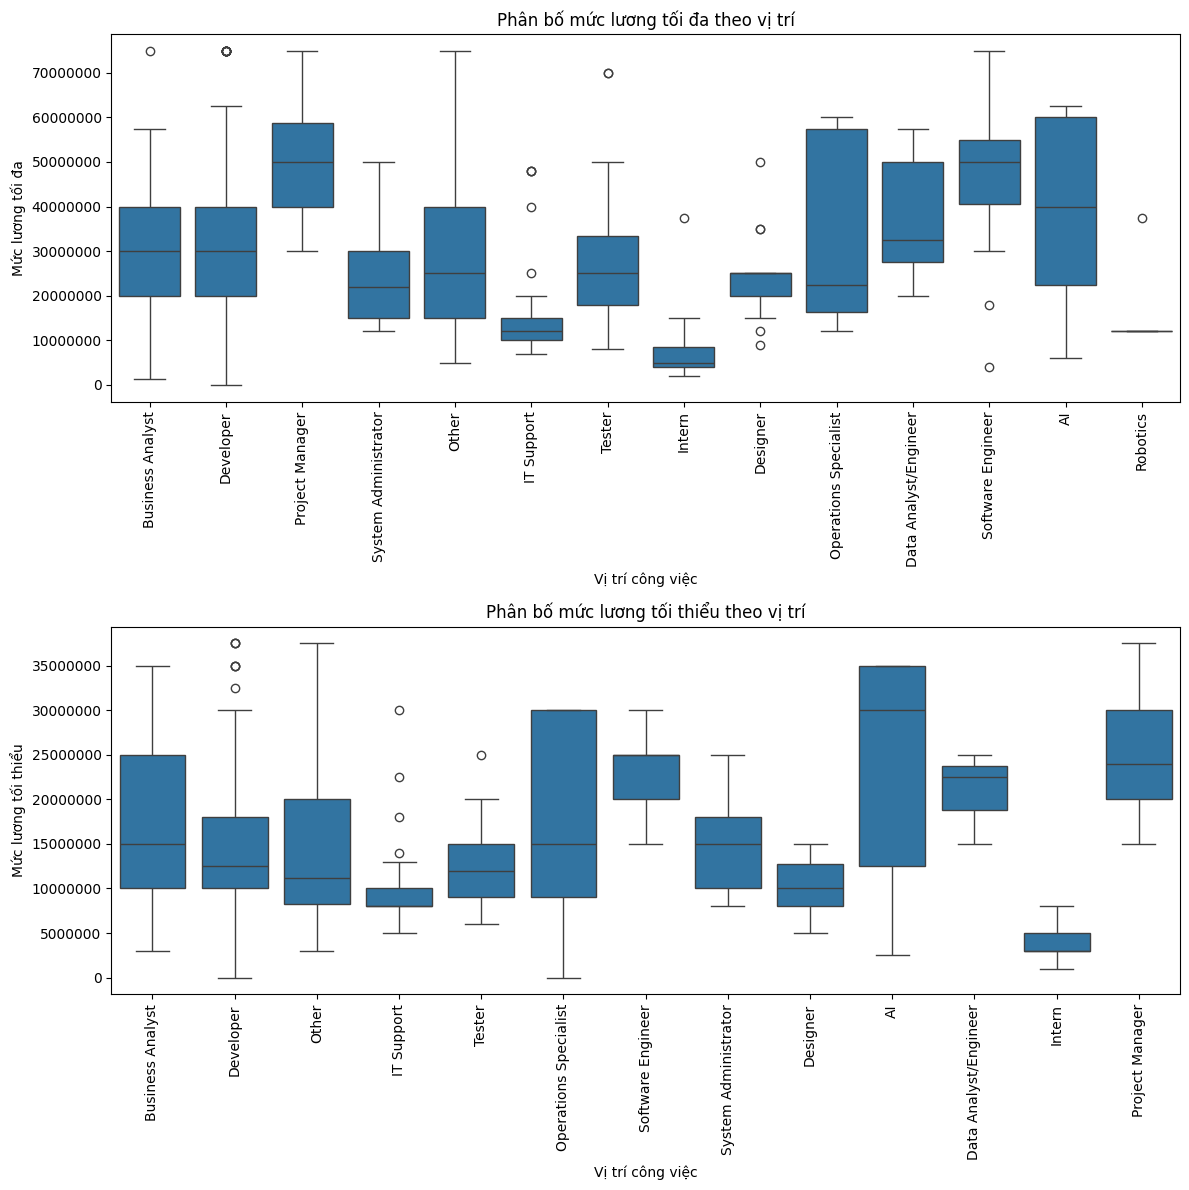

In [22]:
# Tạo figure và các trục con
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Biểu đồ phân bố mức lương tối đa theo vị trí
sns.boxplot(data=final_table_visual_salary_max, x='Job_group', y='max_salary_vnd', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Phân bố mức lương tối đa theo vị trí')
ax[0].set_xlabel('Vị trí công việc')
ax[0].set_ylabel('Mức lương tối đa')
ax[0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax[0].ticklabel_format(style='plain', axis='y')

# Biểu đồ phân bố mức lương tối thiểu theo vị trí
sns.boxplot(data=final_table_visual_salary_min, x='Job_group', y='min_salary_vnd', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Phân bố mức lương tối thiểu theo vị trí')
ax[1].set_xlabel('Vị trí công việc')
ax[1].set_ylabel('Mức lương tối thiểu')
ax[1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax[1].ticklabel_format(style='plain', axis='y')

# Điều chỉnh khoảng cách giữa các trục con để tránh chồng chéo
plt.tight_layout()
plt.show()


In [23]:
#2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực

In [24]:
visual_heatmap = final_table_visual[['city', 'id', 'Job_group']].unique()

In [25]:
job_city_counts = visual_heatmap.group_by(['city', 'Job_group']).agg(pl.count('id').alias('job_count'))

# Chuyển đổi Polars DataFrame sang Pandas DataFrame để sử dụng Seaborn
job_city_counts_pandas = job_city_counts.to_pandas()

# Pivot table để có định dạng phù hợp cho heatmap
heatmap_data = job_city_counts_pandas.pivot(index='Job_group', columns='city', values='job_count')



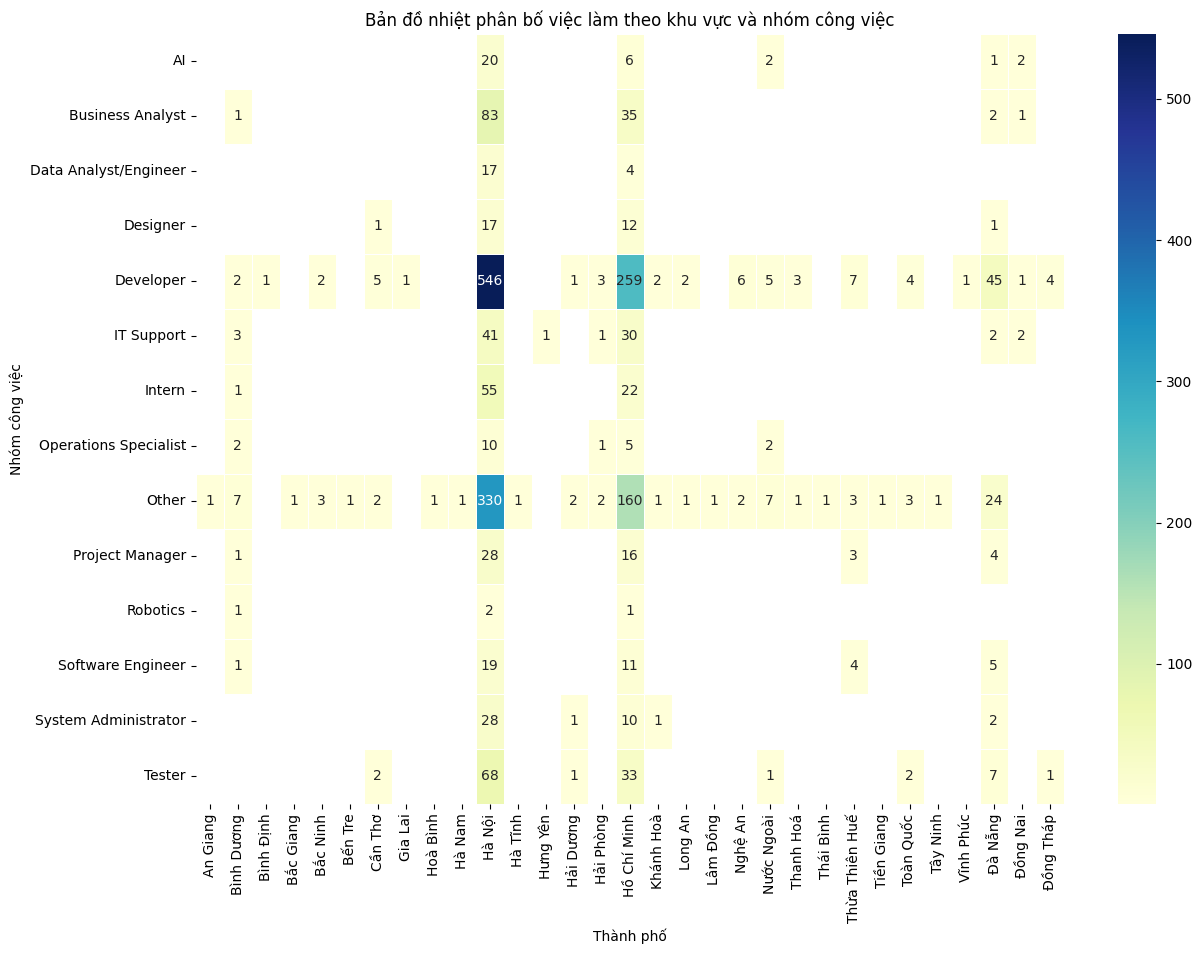

In [26]:
# Vẽ bản đồ nhiệt với định dạng số thực
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="0.0f", linewidths=.5)
plt.title('Bản đồ nhiệt phân bố việc làm theo khu vực và nhóm công việc')
plt.xlabel('Thành phố')
plt.ylabel('Nhóm công việc')
plt.show()


In [27]:
#3. Biểu đồ xu hướng công nghệ hot

In [28]:
data_trend = final_table_visual.group_by(['created_date', 'Job_group']).agg(
    pl.col('id').n_unique().alias('count')
)

In [29]:
data_trend = final_table_visual.group_by('Job_group').agg(
    pl.col('id').n_unique().alias('so_luong_job')
)

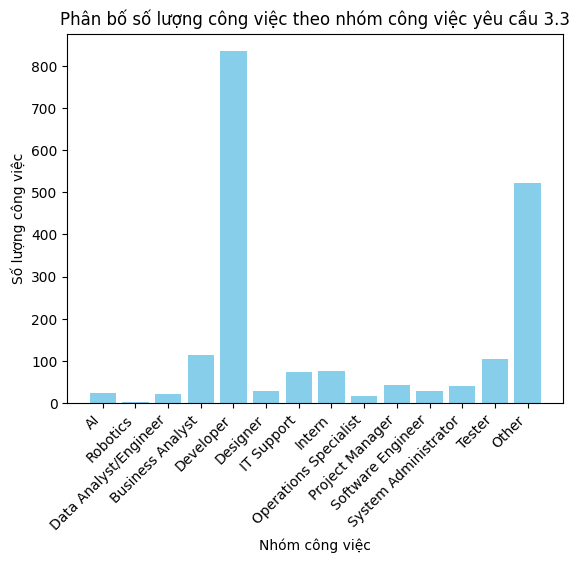

In [30]:
# Chuyển đổi DataFrame sang định dạng phù hợp với matplotlib
job_groups = data_trend['Job_group'].to_list()
so_luong_jobs = data_trend['so_luong_job'].to_list()

# Vẽ biểu đồ cột
fig, ax = plt.subplots()
ax.bar(job_groups, so_luong_jobs, color='skyblue')

# Thêm tiêu đề và nhãn cho trục
plt.title("Phân bố số lượng công việc theo nhóm công việc yêu cầu 3.3")
plt.xlabel("Nhóm công việc")
plt.ylabel("Số lượng công việc")

# Xoay nhãn trục x để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# Hiển thị biểu đồ
plt.show()

In [31]:
"""
### Yêu cầu 1: Chuẩn hóa và làm sạch dữ liệu

1. Chuẩn hóa cột salary về dạng số, xử lý các giá trị như "Thoả thuận", "Trên X triệu", "X - Y triệu", "Tới X triệu", etc.
2. Tạo thêm các cột phụ: min_salary, max_salary, salary_unit (VND/USD)
3. Xử lý cột address để tách thành city và district
4. Chuẩn hóa job_title để gom nhóm các vị trí tương tự (ví dụ: "Software Engineer", "Developer", "Programmer" có thể gom vào một nhóm)

### Yêu cầu 2: Xây dựng Data Pipeline

1. Thiết kế luồng ETL cơ bản: Extract từ CSV -> Transform dữ liệu -> Load vào database (MySQL hoặc PostgresDB)
2. Thiết lập schedule job tự động chạy pipeline
3. Xây dựng error handling cho các trường hợp lỗi phổ biến

### Yêu cầu 3: Phân tích dữ liệu

1. Vẽ biểu đồ phân bố mức lương theo vị trí
2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực
3. Biểu đồ xu hướng công nghệ hot

*Lưu ý quan trọng:*

- Sử dụng version control (git) cho code
- Viết unit test cho các hàm xử lý dữ liệu
"""

'\n### Yêu cầu 1: Chuẩn hóa và làm sạch dữ liệu\n\n1. Chuẩn hóa cột salary về dạng số, xử lý các giá trị như "Thoả thuận", "Trên X triệu", "X - Y triệu", "Tới X triệu", etc.\n2. Tạo thêm các cột phụ: min_salary, max_salary, salary_unit (VND/USD)\n3. Xử lý cột address để tách thành city và district\n4. Chuẩn hóa job_title để gom nhóm các vị trí tương tự (ví dụ: "Software Engineer", "Developer", "Programmer" có thể gom vào một nhóm)\n\n### Yêu cầu 2: Xây dựng Data Pipeline\n\n1. Thiết kế luồng ETL cơ bản: Extract từ CSV -> Transform dữ liệu -> Load vào database (MySQL hoặc PostgresDB)\n2. Thiết lập schedule job tự động chạy pipeline\n3. Xây dựng error handling cho các trường hợp lỗi phổ biến\n\n### Yêu cầu 3: Phân tích dữ liệu\n\n1. Vẽ biểu đồ phân bố mức lương theo vị trí\n2. Vẽ bản đồ nhiệt (heatmap) phân bố việc làm theo khu vực\n3. Biểu đồ xu hướng công nghệ hot\n\n*Lưu ý quan trọng:*\n\n- Sử dụng version control (git) cho code\n- Viết unit test cho các hàm xử lý dữ liệu\n'